## Import lib

In [1]:
from model.lstm import LSTM
from model.rnn import RNN
import pandas as pd
import numpy as np
import torch
import time
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
# param
window_size = 10

# input_dim = 250
input_dim = 250
hidden_dim = 32 
num_layers = 2
output_dim = 1


batch_size = 32
epochs = 10


BNBUSDT=0
BTCUSDT=1
ETHUSDT=2
LTCUSDT=3
XRPUSDT=4

lookback = 20

path_data = "./data/data_2021.csv"
save_model_path = "./results/"
test_path = "./data/data_2023.csv"

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. data has shape equal 250

## Function

In [10]:
def getStateX(data, t, n=10):
    d = t - n + 1
    index = data.index.unique()
    block = data.loc[index[d:t + 1]]
    return np.array(block).reshape(1,-1)

def getStateY(data, t, n=1):
    d = t - n + 1
    index = data.index.unique()
    block = data.loc[index[d:t + 1]]
    value = block[block["symbol"]==BTCUSDT].close.values
    return value
    # return np.array(block).reshape(1,-1)
    
def getDataFromPath(path):
    df = pd.read_csv(path)
    df = df[['open_time', 'close', 'volume', 'count', 'taker_buy_volume', 'symbol']]
    df.set_index('open_time', inplace=True)
    symbol_mapping = {'BNBUSDT': 0, 'BTCUSDT': 1, 'ETHUSDT': 2, 'LTCUSDT': 3, 'XRPUSDT': 4}
    df['symbol'] = df['symbol'].map(symbol_mapping).fillna(df['symbol'])
    return df

def log1p_scaling(data):
    data_en = data.copy()
    data_en['close'] = np.log1p(data['close'])
    data_en['close'] = np.log1p(data['close'])
    data_en['volume'] = np.log1p(data['volume'])
    data_en['count'] = np.log1p(data['count'])
    data_en['taker_buy_volume'] = np.log1p(data['taker_buy_volume'])
    return data_en


def inverse_log1p_scaling(data_en):
    data = data_en.copy()
    data['close'] = np.expm1(data_en['close'].values)
    data['volume'] = np.expm1(data_en['volume'].values)
    data['count'] = np.expm1(data_en['count'].values)
    data['taker_buy_volume'] = np.expm1(data_en['taker_buy_volume'].values)
    return data


## Process data

In [ ]:
data = log1p_scaling(getDataFromPath(path_data))
data.head(16)

In [9]:
data[data["symbol"]==4]

,close,volume,count,taker_buy_volume,symbol
open_time,,,,,
1609459200000,0.200243,18.414400,10.696254,17.764787,4
1609462800000,0.202206,18.570795,10.785373,17.877751,4
1609466400000,0.202042,17.790547,10.329343,17.150310,4
1609470000000,0.204898,18.220456,10.587544,17.692144,4
1609473600000,0.214547,19.971421,12.054750,19.306886,4
...,...,...,...,...,...
1640977200000,0.589674,17.772079,10.979343,16.866856,4
1640980800000,0.594983,17.124024,10.432084,16.525651,4
1640984400000,0.603058,17.222171,10.637225,16.556859,4


In [48]:

window_size=10

In [49]:
length_data = len(data)/5
# Create a DataLoader for your training data
# data_tensor = torch.from_numpy(lambda data: data).type(torch.Tensor)
x_data = []
y_data = []
print("=========================")

for t in range(window_size - 1, int(length_data)  - 2):
    x_data.append(torch.from_numpy(getStateX(data, t, window_size)).type(torch.Tensor))
    y_data.append(torch.from_numpy(getStateY(data, t + 1)).type(torch.Tensor))

In [52]:
# print("===========2=============")
x_train = torch.stack(x_data).to(device)
y_train = torch.stack(y_data).to(device)

dataset = TensorDataset(x_train, y_train)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [53]:
x_train.shape

torch.Size([8749, 1, 250])

## Train data RNN

In [60]:
model_rnn = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, device=device)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model_rnn.parameters(), lr=0.02)

In [61]:
# Training loop
start_time = time.time()

loss_values = []

for epoch in range(200):
    # print("================3==============")
    total_loss = 0.0
    for x_batch, y_batch in data_loader:
        # print(x_batch.shape)
        # print(y_batch.shape)
        y_train_pred = model_rnn(x_batch)
        loss = criterion(y_train_pred, y_batch)
        optimiser.zero_grad()
        loss.backward()
        # print("Epoch ", epoch, "MSE: ", loss.item())
        optimiser.step()
        total_loss += loss.item()
        # break

    loss_values.append(total_loss / length_data)
    if epoch%10==0:
        # print("y_train_pred: ", y_train_pred, "y_batch: ", y_batch)
        print(f"Epoch {epoch}, Average Loss: {total_loss / len(data_loader)}")
        torch.save(model_rnn, "results/model_rnn.pt")
    # break

training_time = time.time() - start_time
print("Training time: {:.2f} seconds".format(training_time))

Epoch 0, Average Loss: 3.675527698992595
Epoch 10, Average Loss: 0.031891463659227876
Epoch 20, Average Loss: 0.021171798407402652
Epoch 30, Average Loss: 0.012556459336842404
Epoch 40, Average Loss: 0.009909830220769343
Epoch 50, Average Loss: 0.010062828743498922
Epoch 60, Average Loss: 0.009995157308035265
Epoch 70, Average Loss: 0.01148999855729554
Epoch 80, Average Loss: 0.0127779807683835
Epoch 90, Average Loss: 0.010358850758040094
Epoch 100, Average Loss: 0.007911581692649527
Epoch 110, Average Loss: 0.006543631120720865
Epoch 120, Average Loss: 0.008761300744886517
Epoch 130, Average Loss: 0.006548730344010218
Epoch 140, Average Loss: 0.0062582655248986764
Epoch 150, Average Loss: 0.00662643785790683
Epoch 160, Average Loss: 0.0028396286983824724
Epoch 170, Average Loss: 0.006810618667730749
Epoch 180, Average Loss: 0.0057443159487502934
Epoch 190, Average Loss: 0.006252859200327148
Training time: 275.80 seconds


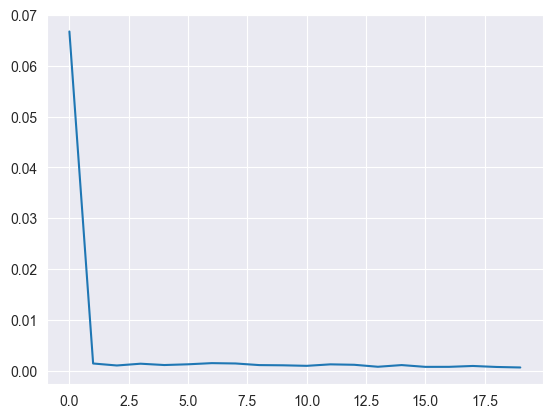

In [171]:
plt.plot(loss_values)

## Train data LSTM

In [84]:

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, device=device)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.3)

In [85]:
# Training loop
start_time = time.time()
loss_values = []

for epoch in range(epochs):
    # print("================3==============")
    total_loss = 0.0
    for x_batch, y_batch in data_loader:
        # print(x_batch.shape)
        # print(y_batch.shape)
        y_train_pred = model(x_batch)
        loss = criterion(y_train_pred, y_batch)
        optimiser.zero_grad()
        loss.backward()
        # print("Epoch ", epoch, "MSE: ", loss.item())
        optimiser.step()
        total_loss += loss.item()
        # break
    loss_values.append(total_loss /  len(data_loader))
    if epoch%100==0:
        print(f"Epoch {epoch}, Average Loss: {total_loss / len(data_loader)}")
    # break

training_time = time.time() - start_time
print("Training time: {:.2f} seconds".format(training_time))

Epoch 0, Average Loss: 1220611282.2857144
Epoch 100, Average Loss: 315029840.0
Epoch 200, Average Loss: 30506250.14285714
Epoch 300, Average Loss: 7846718.40625
Epoch 400, Average Loss: 7704867.455357143
Epoch 500, Average Loss: 8169959.732142857
Epoch 600, Average Loss: 7689896.910714285
Epoch 700, Average Loss: 7612785.522321428
Epoch 800, Average Loss: 7983628.232142857
Epoch 900, Average Loss: 7696777.857142857
Epoch 1000, Average Loss: 7663324.053571428
Epoch 1100, Average Loss: 8407892.642857144
Epoch 1200, Average Loss: 7512657.570033482
Epoch 1300, Average Loss: 8134936.214285715
Epoch 1400, Average Loss: 7713387.428571428
Epoch 1500, Average Loss: 7610797.203125
Epoch 1600, Average Loss: 7732675.25
Epoch 1700, Average Loss: 8042225.321428572
Epoch 1800, Average Loss: 8478346.67857143
Epoch 1900, Average Loss: 7725433.75
Epoch 2000, Average Loss: 7565281.566964285
Epoch 2100, Average Loss: 7547756.741071428
Epoch 2200, Average Loss: 7605290.803571428
Epoch 2300, Average Loss: 7

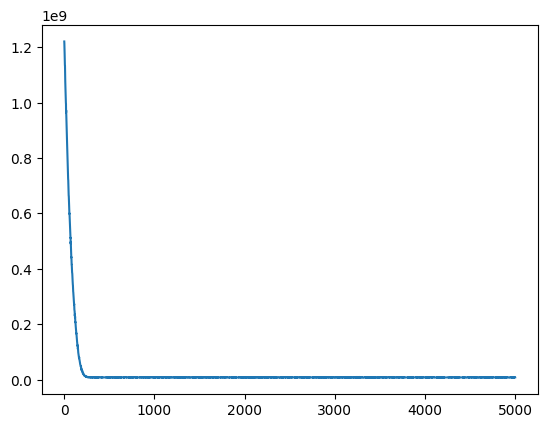

In [86]:
plt.plot(loss_values)

## Save and load model

In [87]:
# save model
torch.save(model.state_dict(), save_model_path+ "model_lstm2.pt")

In [88]:
model2 = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, device=device)
model2.load_state_dict(torch.load(save_model_path+ "model_lstm2.pt"))
model2.eval()

LSTM(
  (lstm): LSTM(250, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

## Predict

In [112]:
# data_test = log1p_scaling(getDataFromPath(test_path))
data_test = log1p_scaling(getDataFromPath("./data/data_2022.csv"))

In [113]:
y_real = []
y_pred = []
time = []

for t in range(window_size - 1, int(length_data)  - window_size):
    try:
        x_test = torch.from_numpy(getStateX(data_test, t, window_size)).type(torch.Tensor).unsqueeze(1).to(device)
        # print(x_test.shape)
        y_pred_sub = model_rnn(x_test)
        # if(t%5==0):
        #     print(y_pred_sub.item())
        # print(getStateY(data, t+1)[0])
        
        time.append(data_test.index[t])
        y_real.append(getStateY(data_test, t+1)[0])
        y_pred.append(y_pred_sub.item())
    except:
        break



In [117]:
df = pd.DataFrame({'time': time ,'y_real': y_real, 'y_pred': y_pred})
df['time'] = pd.to_numeric(df['time']) // 1000
df['time'] = pd.to_datetime(df['time'], unit='s')
df 

,time,y_real,y_pred
0,2022-01-01 01:00:00,10.755028,10.805733
1,2022-01-01 02:00:00,10.752698,10.803383
2,2022-01-01 02:00:00,10.759250,10.814173
3,2022-01-01 02:00:00,10.758042,10.815409
4,2022-01-01 02:00:00,10.755990,10.810307
...,...,...,...
2890,2022-01-25 03:00:00,10.367388,10.430817
2891,2022-01-25 04:00:00,10.364570,10.442244
2892,2022-01-25 04:00:00,10.369022,10.446178
2893,2022-01-25 04:00:00,10.367184,10.436305


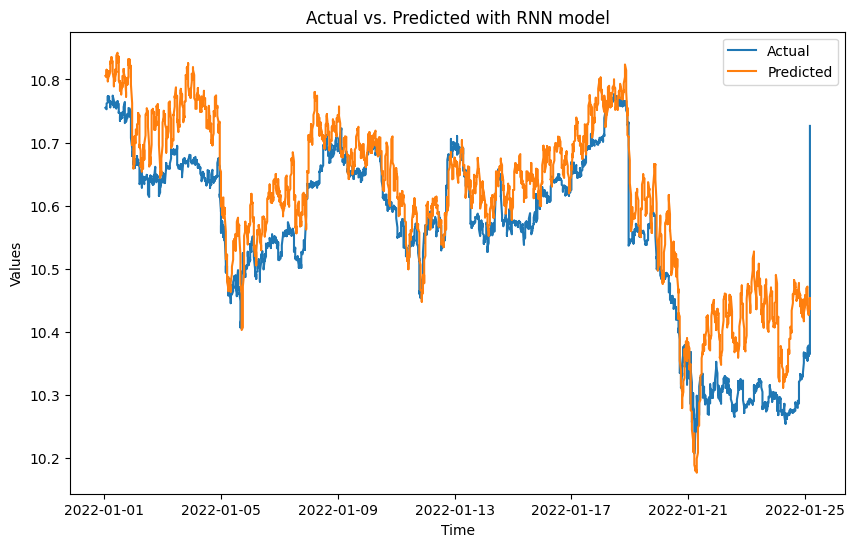

In [120]:
# Create a pandas DataFrame
# df = pd.DataFrame({'y_real': y_real, 'y_pred': y_pred})
# Plot the data using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(df["time"],df['y_real'], label='Actual')
plt.plot(df["time"],df['y_pred'], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted with RNN model')
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()

# Data has shape 10

In [3]:
def getStateX(data, t, n=10):
    d = t - n + 1
    index = data.index.unique()
    block = data.loc[index[d:t + 1]]
    return np.array(block).reshape(1,-1)

def getStateY(data, t, n=1):
    d = t - n + 1
    index = data.index.unique()
    block = data.loc[index[d:t + 1]]
    # value = block[block["symbol"]==BTCUSDT].close.values
    return block
    # return np.array(block).reshape(1,-1)
    
def getTestStockDataVec(path):
    df = pd.read_csv(path)
    df = df[df["symbol"]=='BTCUSDT']
    df = df[['open_time', 'close']]
    df.set_index('open_time', inplace=True)
    return df

# length_data  = int(len(data.index.unique())/10)

In [5]:
data = getTestStockDataVec(path_data)
data.head()

,close
open_time,
1609459200000,29015.00
1609462800000,29448.40
1609466400000,29237.06
1609470000000,29302.11
1609473600000,29237.07


### Normalize data

In [18]:
prices = data.copy()

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
prices["close"] = scaler.fit_transform(data)
prices

,close
open_time,
1609459200000,0.000000
1609462800000,0.010917
1609466400000,0.005593
1609470000000,0.007232
1609473600000,0.005594
...,...
1640977200000,0.420471
1640980800000,0.424542
1640984400000,0.435729


In [32]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    print(test_set_size)
    print(train_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [68]:
x_train, y_train, x_test, y_test = split_data(prices, lookback+1)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

1748
6991
x_train.shape =  (6991, 20, 1)
y_train.shape =  (6991, 1)
x_test.shape =  (1748, 20, 1)
y_test.shape =  (1748, 1)


In [48]:
len(x_train)

6992

In [69]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor).view(len(x_train),-1,lookback).to(device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).view(len(x_test),-1,lookback).to(device)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor).to(device)
# y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
# y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [57]:
x_train[0].unsqueeze(1)

tensor([[[0.0000, 0.0109, 0.0056, 0.0072, 0.0056, 0.0050, 0.0046, 0.0023,
          0.0003, 0.0054, 0.0062, 0.0082, 0.0061, 0.0121, 0.0086, 0.0049,
          0.0078, 0.0021, 0.0018, 0.0008]]])

In [70]:
dataset = TensorDataset(x_train, y_train_lstm)
data_loader = DataLoader(dataset, batch_size=batch_size,)

In [74]:
for  x_batch, y_batch in data_loader:
    print( x_batch.shape, y_batch.shape)
    break

torch.Size([32, 1, 20]) torch.Size([32, 1])


In [75]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, device=device)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.1)

In [76]:
model(x_train[0].unsqueeze(1))

tensor([[0.0583]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [79]:
import time

hist = np.zeros(200)
start_time = time.time()
lstm = []

for t in range(200):
    y_train_pred = model(x_train)

    # print(y_train_pred.shape)
    # print(y_train_lstm.shape)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.0050937882624566555
Epoch  1 MSE:  0.008704368025064468
Epoch  2 MSE:  0.00880308449268341
Epoch  3 MSE:  0.005034254398196936
Epoch  4 MSE:  0.008857447654008865
Epoch  5 MSE:  0.004540215712040663
Epoch  6 MSE:  0.00374383432790637
Epoch  7 MSE:  0.00614693108946085
Epoch  8 MSE:  0.004406773950904608
Epoch  9 MSE:  0.0026911008171737194
Epoch  10 MSE:  0.00377975357696414
Epoch  11 MSE:  0.0046227299608290195
Epoch  12 MSE:  0.0038197487592697144
Epoch  13 MSE:  0.0034175103064626455
Epoch  14 MSE:  0.004051323048770428
Epoch  15 MSE:  0.0040845670737326145
Epoch  16 MSE:  0.0030784804839640856
Epoch  17 MSE:  0.0025231745094060898
Epoch  18 MSE:  0.002797920722514391
Epoch  19 MSE:  0.0024447590112686157
Epoch  20 MSE:  0.001790660317055881
Epoch  21 MSE:  0.0021753660403192043
Epoch  22 MSE:  0.002250548219308257
Epoch  23 MSE:  0.0016151363961398602
Epoch  24 MSE:  0.0018798302626237273
Epoch  25 MSE:  0.0017922351835295558
Epoch  26 MSE:  0.0012950964737683535
E

In [81]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.cpu().detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.cpu().detach().numpy()))

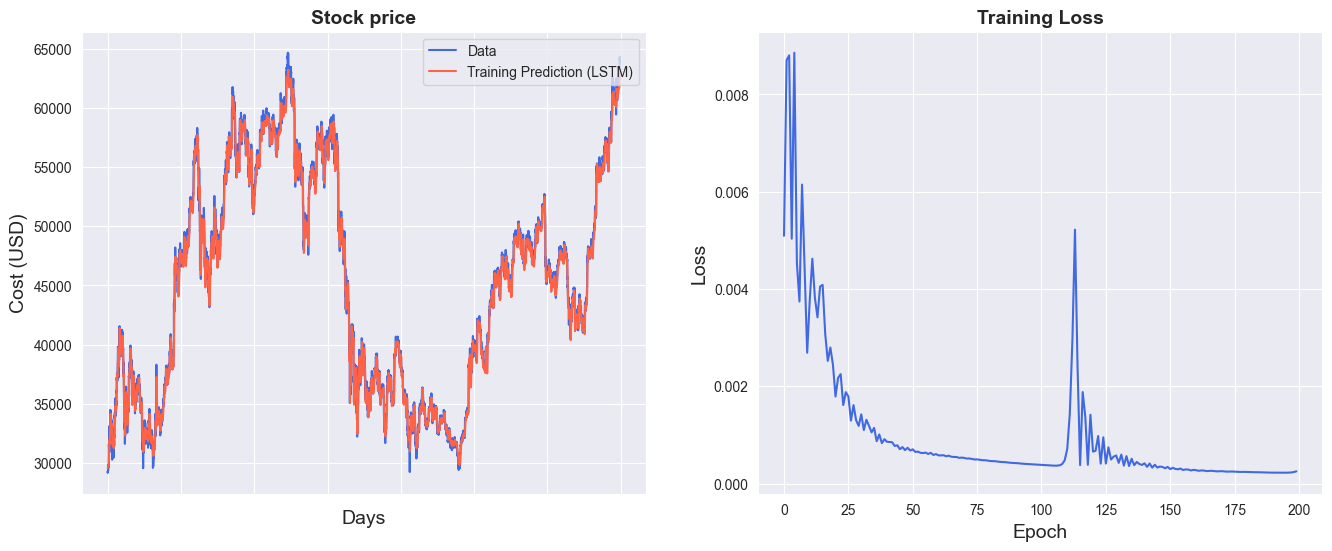

In [83]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [85]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.cpu().detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.cpu().detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.cpu().detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.cpu().detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 631.46 RMSE
Test Score: 706.29 RMSE


In [5]:
print(getStateX(data, 10,10))
print(getStateY(data, 11).values[0][0])

[[29448.4  29237.06 29302.11 29237.07 29213.8  29197.3  29107.71 29025.89
  29229.6  29259.29]]
29341.99


In [86]:
# Create a DataLoader for your training data
# data_tensor = torch.from_numpy(lambda data: data).type(torch.Tensor)
length_data = len(data)
x_data = []
y_data = []
print("=========================")

for t in range(window_size - 1, int(length_data)  - 2):
    x_data.append(torch.from_numpy(getStateX(data, t, window_size)).type(torch.Tensor))
    y_data.append(torch.from_numpy(getStateY(data, t + 1).values[0]).type(torch.Tensor))

In [87]:
# print("===========2=============")
x_train = torch.stack(x_data).to(device)
y_train = torch.stack(y_data).to(device)

dataset = TensorDataset(x_train, y_train)
data_loader = DataLoader(dataset, batch_size=batch_size)

In [88]:
model = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, device=device)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.1)

In [89]:
# Training loop
start_time = time.time()
loss_values = []

for epoch in range(100):
    # print("================3==============")
    total_loss = 0.0
    for x_batch, y_batch in data_loader:
        # print(x_batch.shape)
        # print(y_batch.shape)
        y_train_pred = model(x_batch)
        loss = criterion(y_train_pred, y_batch)
        optimiser.zero_grad()
        loss.backward()
        # print("Epoch ", epoch, "MSE: ", loss.item())
        optimiser.step()
        total_loss += loss.item()
        # break
    loss_values.append(total_loss /  len(data_loader))
    print(f"Epoch {epoch}, Average Loss: {total_loss / len(data_loader)}")
    
    # if epoch%100==0:
    #     print(f"Epoch {epoch}, Average Loss: {total_loss / len(data_loader)}")
    # break

training_time = time.time() - start_time
print("Training time: {:.2f} seconds".format(training_time))

Epoch 0, Average Loss: 2067833418.4525547
Epoch 1, Average Loss: 677212826.4963504
Epoch 2, Average Loss: 117306272.32977875
Epoch 3, Average Loss: 103388312.29482208
Epoch 4, Average Loss: 105608328.19844891
Epoch 5, Average Loss: 106091510.90391195
Epoch 6, Average Loss: 106355789.24019161
Epoch 7, Average Loss: 106539867.745552
Epoch 8, Average Loss: 106672259.14341925
Epoch 9, Average Loss: 106768155.23811017
Epoch 10, Average Loss: 106838237.18550411
Epoch 11, Average Loss: 106889919.2133896
Epoch 12, Average Loss: 106928052.50326471
Epoch 13, Average Loss: 106956142.49304289
Epoch 14, Average Loss: 106976978.57940808
Epoch 15, Average Loss: 106992492.20004562
Epoch 16, Average Loss: 107003652.35467039
Epoch 17, Average Loss: 107011990.95711678
Epoch 18, Average Loss: 107017983.09784158
Epoch 19, Average Loss: 107022386.81076072
Epoch 20, Average Loss: 107025439.01284501
Epoch 21, Average Loss: 107027515.41734147
Epoch 22, Average Loss: 107029145.70283987
Epoch 23, Average Loss: 1

KeyboardInterrupt: 

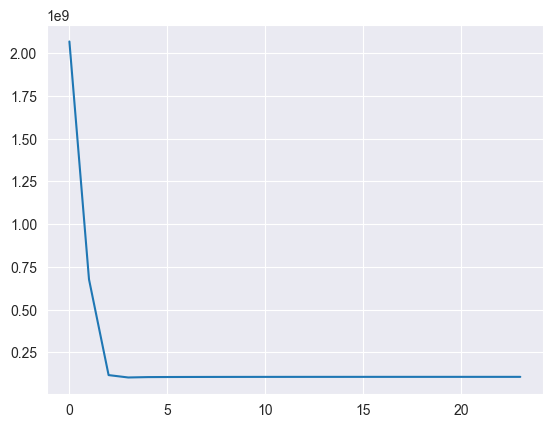

In [90]:
plt.plot(loss_values)

tensor([[[29015.0000, 29448.4004, 29237.0605, 29302.1094, 29237.0703,
          29213.8008, 29197.3008, 29107.7109, 29025.8906, 29229.5996]]])
34880.2109375
tensor([[[29448.4004, 29237.0605, 29302.1094, 29237.0703, 29213.8008,
          29197.3008, 29107.7109, 29025.8906, 29229.5996, 29259.2891]]])
34880.2109375
tensor([[[29237.0605, 29302.1094, 29237.0703, 29213.8008, 29197.3008,
          29107.7109, 29025.8906, 29229.5996, 29259.2891, 29341.9902]]])
34880.2109375
tensor([[[29302.1094, 29237.0703, 29213.8008, 29197.3008, 29107.7109,
          29025.8906, 29229.5996, 29259.2891, 29341.9902, 29257.8203]]])
34880.2109375
tensor([[[29237.0703, 29213.8008, 29197.3008, 29107.7109, 29025.8906,
          29229.5996, 29259.2891, 29341.9902, 29257.8203, 29493.6602]]])
34880.2109375
tensor([[[29213.8008, 29197.3008, 29107.7109, 29025.8906, 29229.5996,
          29259.2891, 29341.9902, 29257.8203, 29493.6602, 29354.5801]]])
34880.2109375
tensor([[[29197.3008, 29107.7109, 29025.8906, 29229.5996, 

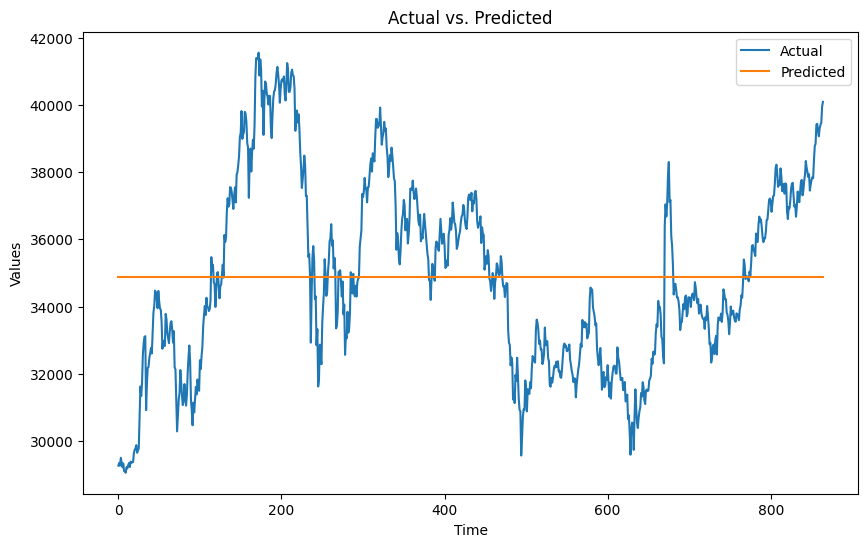

In [54]:
data_test = getTestStockDataVec(test_path)
y_real = []
y_pred = []

for t in range(window_size - 1, int(length_data)  - 2):
    x_test = torch.from_numpy(getStateX(data, t, window_size)).type(torch.Tensor).unsqueeze(1)
    print(x_test)
    y_pred_sub = model(x_test)
    print(y_pred_sub.item())
    # print(getStateY(data, t+1)[0])
    
    y_real.append(getStateY(data, t+1).values[0][0])
    y_pred.append(y_pred_sub.item())
    # break

# Create a pandas DataFrame
df = pd.DataFrame({'y_real': y_real, 'y_pred': y_pred})
# Plot the data using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(df['y_real'], label='Actual')
plt.plot(df['y_pred'], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted')
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()